In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

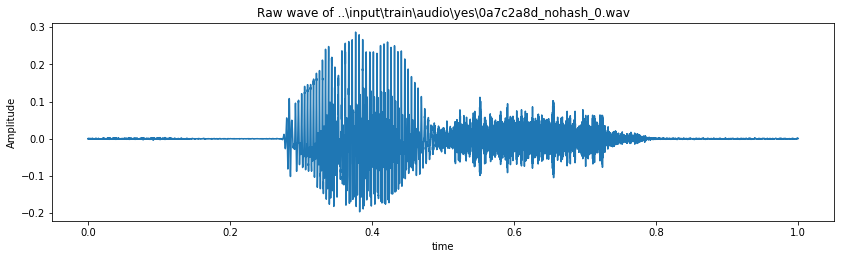

In [6]:
train_audio_path = "E:\\TF\\train\\audio\\"
samples, sample_rate = librosa.load(train_audio_path+'yes\\0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '..\\input\\train\\audio\\yes\\0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [7]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [8]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

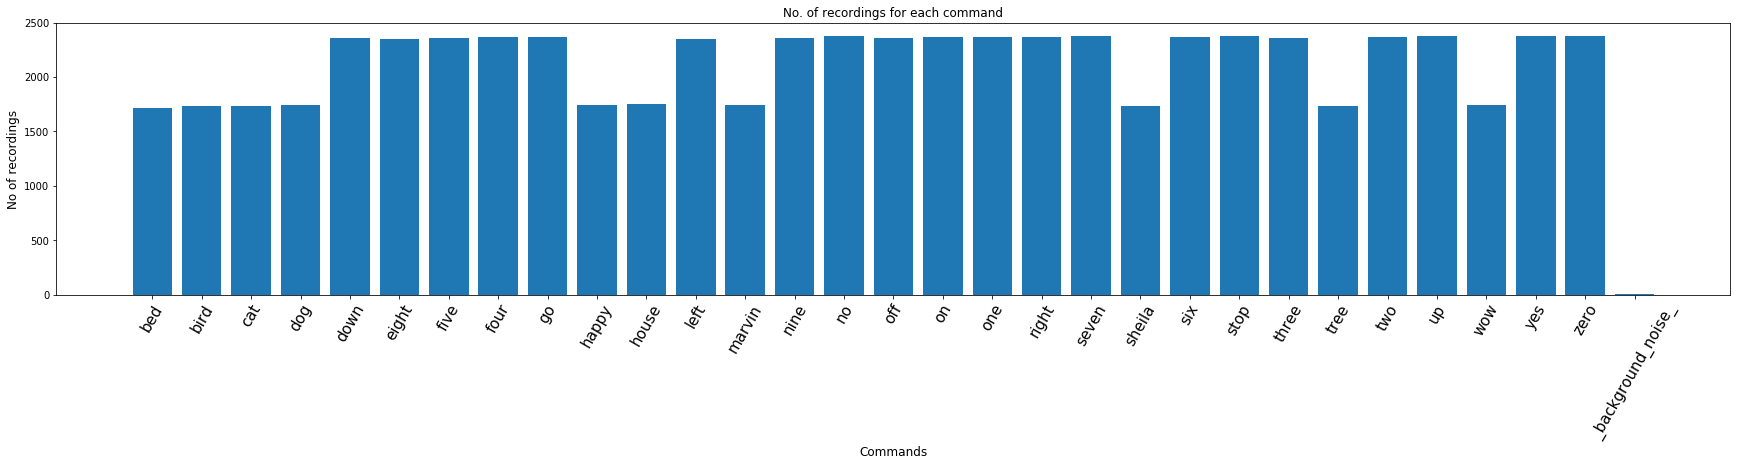

In [9]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [10]:
train_audio_path = "E:\\TF\\train\\audio\\"

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [12]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [13]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [14]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0         
__________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))


In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [16]:
from keras.models import load_model
model=load_model('best_model.hdf5')

In [17]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [18]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: on
Text: on


In [45]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [46]:
filepath='C:\\Users\\Rakesh\\Desktop\\Refactored_Py_DS_ML_Bootcamp-master'

In [47]:
samples, sample_rate = librosa.load(filepath + '\\' + 'yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000) 

In [48]:
predict(samples)


'right'